# Kaggle 2018: Home Loan Credit

This project serves as the Capstone Project I of my SpringBoard Data Science Career Track curriculum. The objective is to demonstrate what I have learnt so-far from SpringBoard courses, and the implementation to a real-word dataset and problem. The dataset is from [Kaggle Competition: Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk). Although there are many data file available, I will only make use of the major dataset "application_{train|test}.csv" during this project to limit my scope. Further exploration and integration of the other datasets will be done in the future, or possibly my next Capstone Project. 

The key question that I am trying to answer is: 
* What are the factors contributing to the credibility of home loan applicants? 
* How much improvement does the model introduce to the financial institute in terms of its business revenue?


## Loading Libraries

### standard packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import os
from tqdm import tqdm  # time for-loops, for i in tqdm(range(10000)):
import time

# feature preparation
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from scipy import interp
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%load_ext watermark
%watermark -a "by Bing Z." -d -t -v -p numpy,pandas,sklearn,xgboost,matplotlib,seaborn

by Bing Z. 2019-03-14 22:43:41 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.2
pandas 0.24.1
sklearn 0.20.1
xgboost 0.81
matplotlib 3.0.2
seaborn 0.9.0


### customized modules

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load my functions
import sys
sys.path.insert(0, '../src') # use absolute directory

In [4]:
from data import * # functions for data manipulation and mostly during EDA stage
from features import * # functions for visualization
from visualization import * # functions for visualization

## User Inputs

In [5]:
dir_dat_raw = "../data/raw/"
dir_dat_interim = "../data/interim/"
dir_dat_processed = "../data/processed/"
dir_reports = "../reports/"
dir_reports_figures = "../reports/figures/"
fname_dat_raw = "application_train.csv"
fname_dat_interim = "application_train.pickle"

### Read data and save in pickle format

In [6]:
# # read raw data
# df_raw = pd.read_csv(dir_dat_raw + fname_dat_raw)

# # # save to pickle
# with open(dir_dat_interim+fname_dat_interim, 'wb') as handle:
#     pickle.dump(df_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # read from pickle
with open(dir_dat_interim+fname_dat_interim, 'rb') as handle:
    df_raw = pickle.load(handle)

In [8]:
df_raw.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_raw.shape

(307511, 122)

## Exploratory Data Analysis (EDA)

1. Check the consistency of data type, overall statistics 
1. Check the distribution of features and the correlation with the label variable.
1. Deal with missing values and outliers. 
1. Check the colinearity among features. 


### Data Type and Statistics
It is found that all the string variables are nominal categorical variables, which requires one-hot encoding. 


#### summarize statistics, examine data type

In [9]:
# summarize: statistics | missing value | data type | sample data
df_raw_stat = pd.concat([pd.DataFrame(df_raw.dtypes,columns=['type']), func_df_describe_all(df_raw),df_raw.head().T], axis=1)
df_raw_stat.to_excel('../reports/EDA-data-summary.xlsx', sheet_name='statistics', index=True)
func_df_display_all(df_raw_stat)

,type,count,unique,top,freq,mean,std,min,25%,50%,75%,max,miss_perc,0,1,2,3,4
SK_ID_CURR,int64,307511,NaN,NaN,NaN,278181,102790,100002,189146,278202,367142,456255,0.000000,100002,100003,100004,100006,100007
TARGET,int64,307511,NaN,NaN,NaN,0.0807288,0.272419,0,0,0,0,1,0.000000,1,0,0,0,0
NAME_CONTRACT_TYPE,object,307511,2,Cash loans,278232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,object,307511,3,F,202448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,M,F,M,F,M
FLAG_OWN_CAR,object,307511,2,N,202924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,N,N,Y,N,N
FLAG_OWN_REALTY,object,307511,2,Y,213312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Y,N,Y,Y,Y
CNT_CHILDREN,int64,307511,NaN,NaN,NaN,0.417052,0.722121,0,0,0,1,19,0.000000,0,0,0,0,0
AMT_INCOME_TOTAL,float64,307511,NaN,NaN,NaN,168798,237123,25650,112500,147150,202500,1.17e+08,0.000000,202500,270000,67500,135000,121500
AMT_CREDIT,float64,307511,NaN,NaN,NaN,599026,402491,45000,270000,513531,808650,4.05e+06,0.000000,406598,1.2935e+06,135000,312682,513000
AMT_ANNUITY,float64,307499,NaN,NaN,NaN,27108.6,14493.7,1615.5,16524,24903,34596,258026,0.003902,24700.5,35698.5,6750,29686.5,21865.5


#### scan data types and save a copy

In [9]:
# feature_dict, feature_df = func_df_col_names_by_type(df_raw)

# with open(dir_dat_processed+'/feature_names.pickle', 'wb') as handle:
#     pickle.dump([feature_dict, feature_df], handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data 
with open(dir_dat_processed+'/feature_names.pickle', 'rb') as handle:
    [feature_dict, feature_df] = pickle.load(handle)

feature_df

,feature_type,feature_num,feature_list
0,cols_number,105,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A..."
1,cols_string,16,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR..."
2,cols_binary,32,"[FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, ..."
3,cols_number_exclude_binary,73,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A..."
4,cols_string_include_binary,48,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR..."
5,cols_datetime,0,[]
6,cols_timedelta,0,[]
7,cols_category,0,[]
8,cols_others,0,[]


#### levels within categorical features

In [11]:
df_cat = func_df_cat_levels(df_raw[feature_dict['cols_string']])
df_cat

,features,level_num,levels
0,NAME_CONTRACT_TYPE,2,"[Cash loans, Revolving loans]"
2,FLAG_OWN_CAR,2,"[N, Y]"
3,FLAG_OWN_REALTY,2,"[Y, N]"
15,EMERGENCYSTATE_MODE,2,"[No, nan, Yes]"
1,CODE_GENDER,3,"[M, F, XNA]"
13,HOUSETYPE_MODE,3,"[block of flats, nan, terraced house, specific..."
12,FONDKAPREMONT_MODE,4,"[reg oper account, nan, org spec account, reg ..."
6,NAME_EDUCATION_TYPE,5,"[Secondary / secondary special, Higher educati..."
7,NAME_FAMILY_STATUS,6,"[Single / not married, Married, Civil marriage..."
8,NAME_HOUSING_TYPE,6,"[House / apartment, Rented apartment, With par..."


### Distributions 

#### y-label: check dataset balance 
Observation: ~8% data labeled as 'default' cases. <br>
Implecation: consider upsampling the minority class during model training. 

0    91.927118
1     8.072882
Name: TARGET, dtype: float64


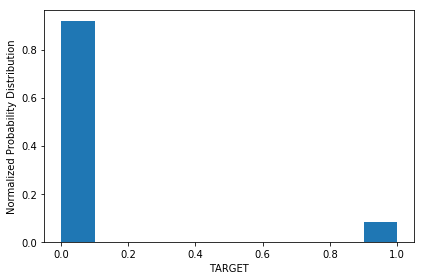

In [21]:
col = 'TARGET'
print(df_raw[col].value_counts(normalize=True) * 100)
fig = plt.figure(figsize=[6,4])
plt.hist(df_raw[col], weights=np.ones(df_raw[col].count()) / df_raw[col].count())  # .count() excludes NaN
plt.xlabel(col)
plt.ylabel('Normalized Probability Distribution')
plt.tight_layout()
plt.savefig(dir_reports_figures+'eda-target-'+col+'.png')
plt.show()

#### Histogram

In [43]:
def func_eda_hist_by_label_plot(df_X, Y, prefix='', figsize=(6,4), dir_png='../reports/figures/'):
    """function to plot the normalized probability density distribution
    Keyword arguments: df_X (feature dataframe), y (label pandas series), dir_png (output dir); Return: PNG files
    """
    import numpy as np
    
    y_uniques = Y.unique()  # unique labels, e.g. 0 or 1
    
    for col in df_X.columns:
        # filter nan vales 
        mask = ~df_X[col].isnull()
        x = df_X.loc[mask, col]
        y = Y[mask]
        
        # plot
        fig = plt.figure(figsize=figsize)
        plt.hist([x[y == y_unique] for y_unique in y_uniques], 
                 label=y_uniques, 
                 weights=[np.ones(x[y == y_unique].count()) / x[y == y_unique].count() for y_unique in y_uniques])#density=True)
        plt.xlabel(col)
        plt.ylabel('Normalized Probability Distribution')
        plt.legend()
        plt.tight_layout()
#         plt.savefig(dir_reports_figures+'eda-hist-'+prefix+col+'.png')
#         plt.close(fig)
        plt.show()
    
    return

In [23]:
# Loop through all parameters
# # plot the normalized probability density function colored by y 
# func_eda_df_hist_by_label(df_raw[feature_dict['cols_string']], df_raw['TARGET'], 
#                           normal=True, prefix='density-str-', dir_png='../reports/figures/')
# func_eda_df_hist_by_label(df_raw[feature_dict['cols_number']], df_raw['TARGET'], 
#                           normal=True, prefix='density-num-', dir_png='../reports/figures/')

By plotting the normalized probability density distribution colored by TARGET label, most distributions are found to have similar distributions, thus no correlation with the label. The following features are found to have relatively more distinct distributions under 'default' (y=1) and 'normal' (y=0) cases. 
* 'DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER'

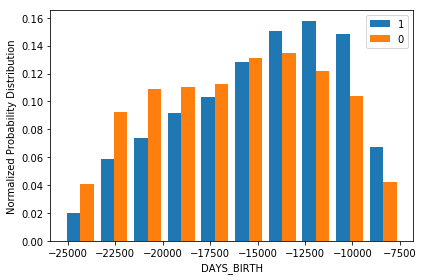

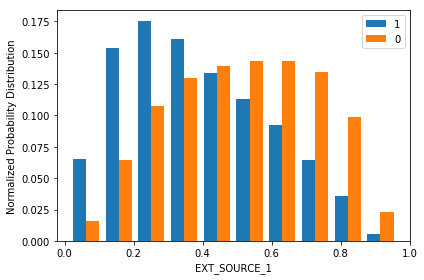

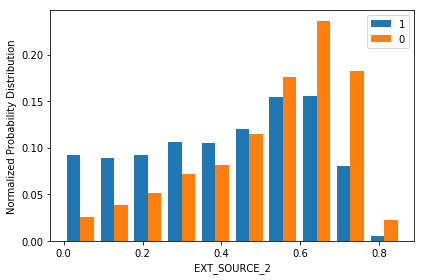

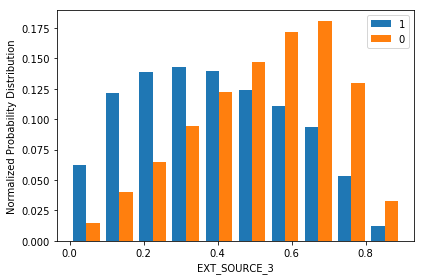

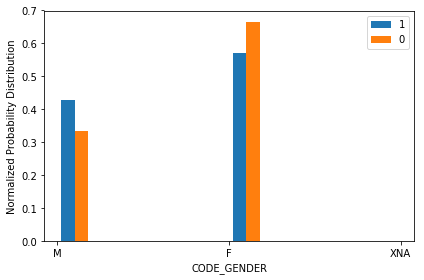

In [44]:
# the plots below lists down the features that have 
cols_temp = ['DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER']
func_eda_hist_by_label_plot(df_raw[cols_temp], df_raw['TARGET'])

#### Box plot for continuous variable to detect outliers

In [56]:
# Loop through all parameters
# func_eda_df_box_plot(df_raw[feature_dict['cols_number_exclude_binary']], 
#                      prefix='', figsize=(12,2), dir_png='../reports/figures/eda-box/')

By plotting the boxplots, we can identify that 'DAYS_EMPLOYED' contains outliers with value = 365243 days, which obviously represents erroneous data, as the days are defined as negative values. 

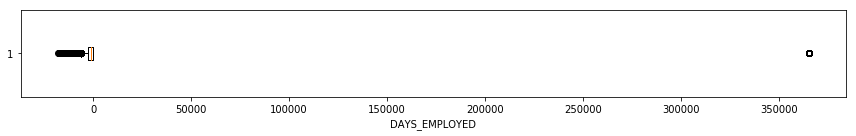

In [76]:
# # the plots below lists down the features that have 
cols_temp = ['DAYS_EMPLOYED']
for col in cols_temp:
    fig = plt.figure(figsize=(12,2))
    plt.boxplot(df_raw[col].dropna(), vert=False)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

Check the boxplot again after replacing outliers with median value. 

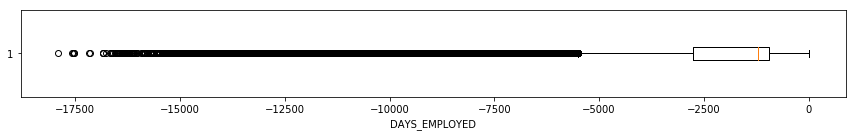

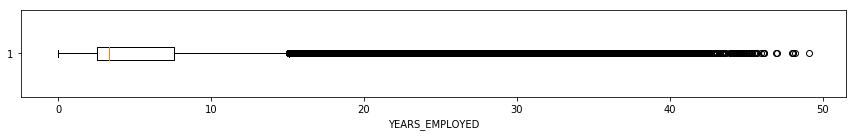

In [48]:
# # replace outliers with median
median_value = df_raw['DAYS_EMPLOYED'].median(skipna=True)
data = df_raw['DAYS_EMPLOYED'].replace(to_replace=365243, value = median_value, inplace=False)
filtered_data = data[~np.isnan(data)]
fig = plt.figure(figsize=(12,2))
plt.boxplot(filtered_data, vert=False)
plt.xlabel('DAYS_EMPLOYED')
plt.tight_layout()
plt.show()

# convert 'DAYS_EMPLOYED' into 'YEARS_EMPLOYED'
fig = plt.figure(figsize=(12,2))
plt.boxplot(-filtered_data/365, vert=False)
plt.xlabel('YEARS_EMPLOYED')
plt.tight_layout()
plt.show()

All features in units of Days as below. Only 'DAYS_EMPLOYED' show abnormal results. 

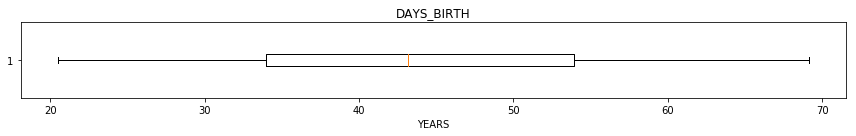

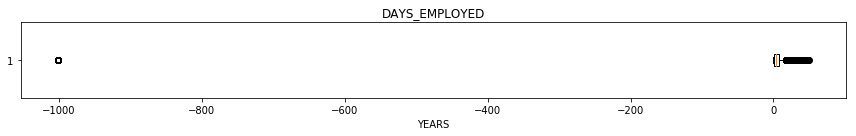

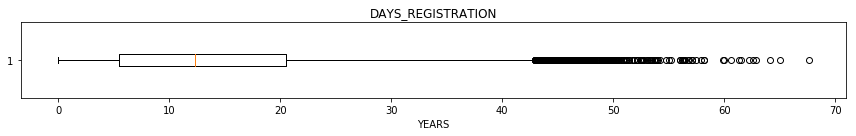

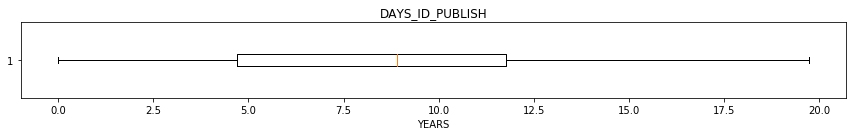

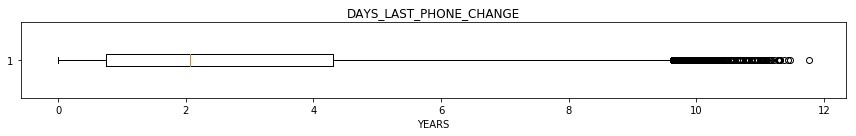

In [75]:
col_in_days = [x for x in df_raw.columns.values if 'days' in x.lower()]

for c in col_in_days:
    fig = plt.figure(figsize=(12,2))
    plt.boxplot(-df_raw[c].dropna()/365, vert=False)
    plt.title(c)
    plt.xlabel('YEARS')
    plt.tight_layout()
    plt.show()

### Missing Values 

#### Correlation of missing values 

In [65]:
# find the correlation of missing values for features with high missing value percentages
percent_missing = df_raw.isnull().sum() * 100 / len(df_raw)
col_names = df_raw.columns

Missing value heatmap saved at ../reports/figures/eda-missingno-heatmap-above60perc.png


C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Missing value heatmap saved at ../reports/figures/eda-missingno-correlation-above60perc.png


<Figure size 1008x576 with 0 Axes>

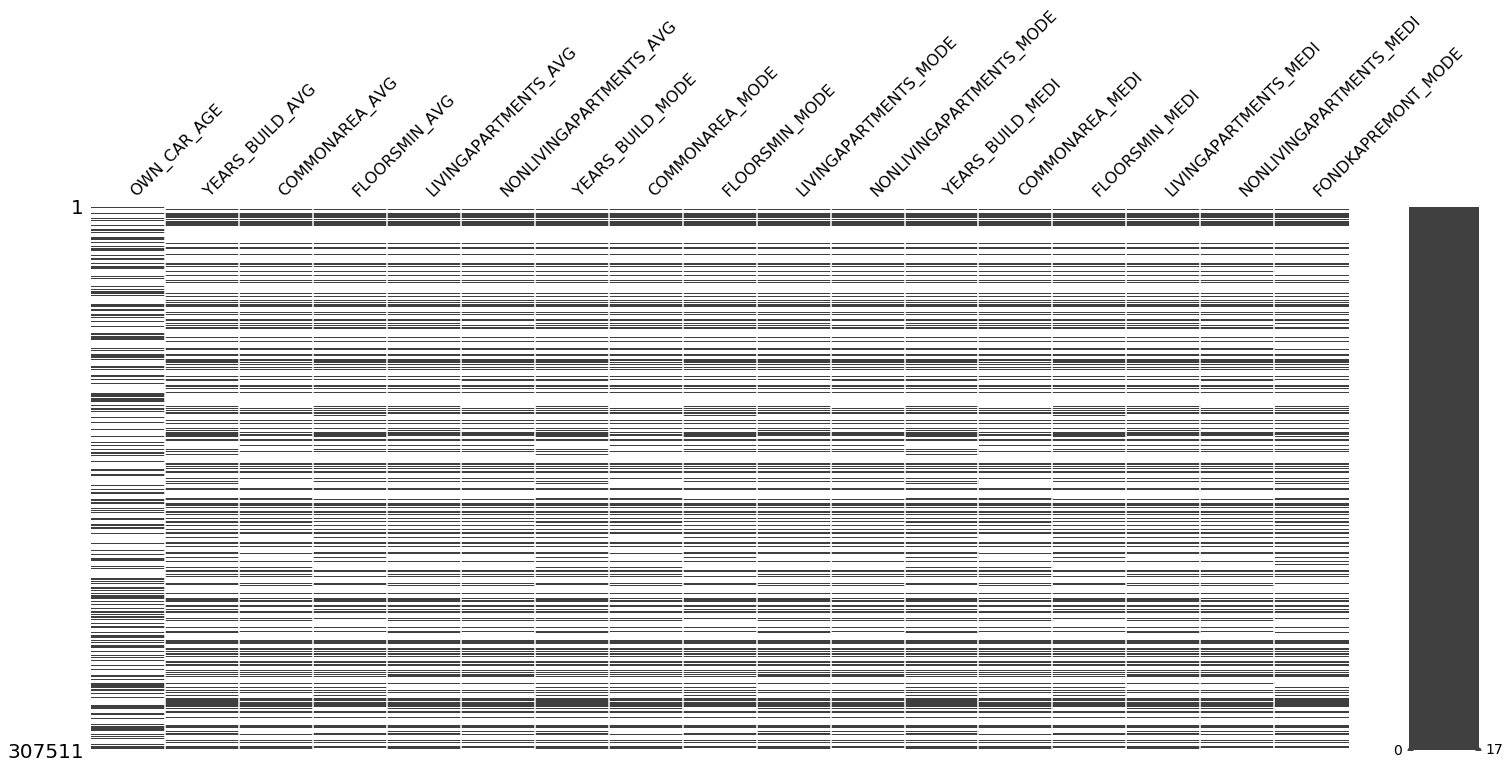

<Figure size 1008x576 with 0 Axes>

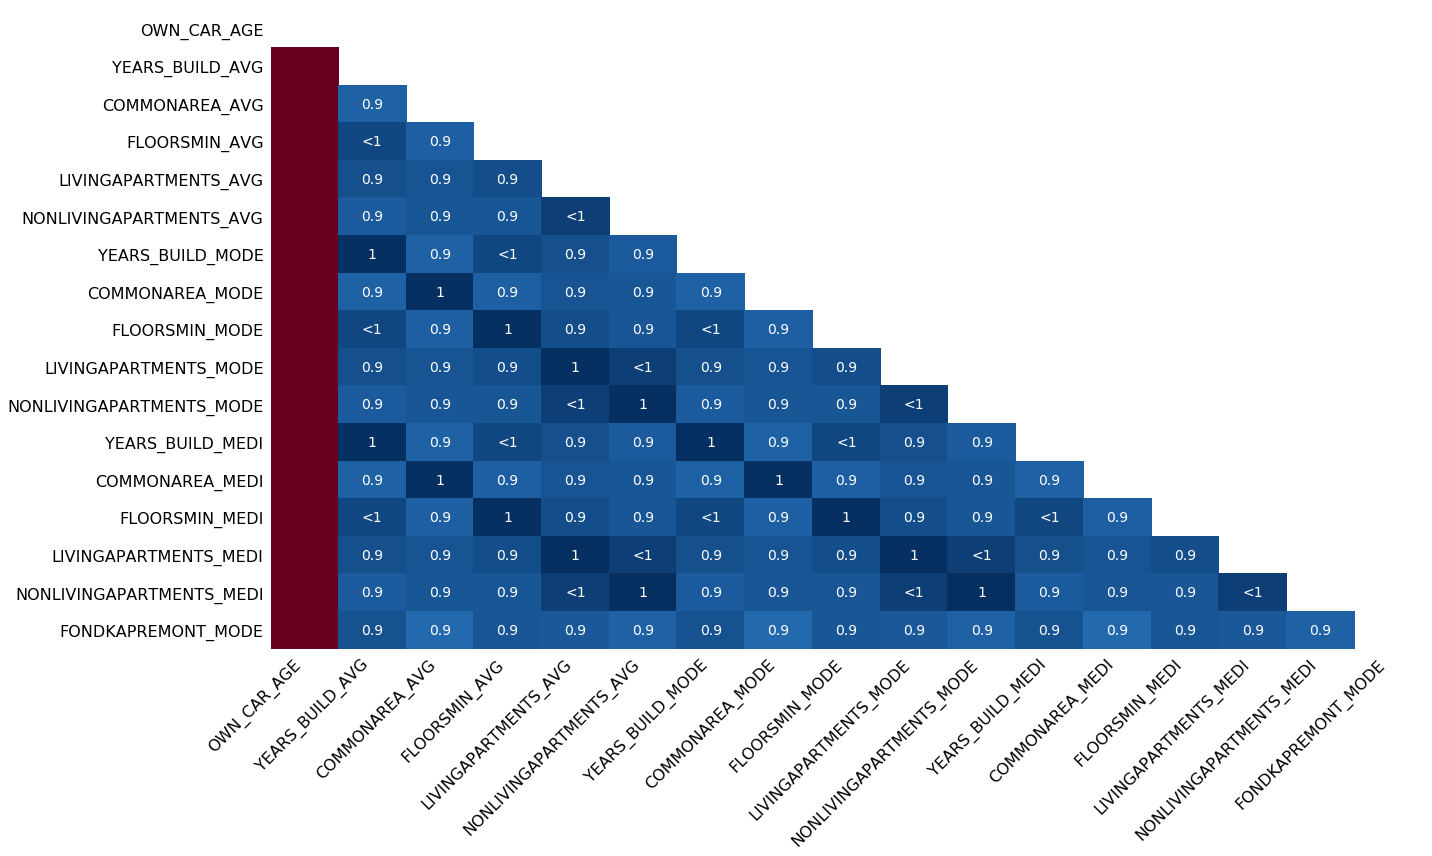

In [10]:
func_eda_df_missingno(df_raw.loc[:,col_names[percent_missing>60]],prefix='above60perc')

## Pre-processing 

### split training and test sets (DataFrame)

In [48]:
# stratified split
label_name = 'TARGET'
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_raw.drop(label_name,axis=1), df_raw[label_name],
                                                                test_size = 0.20, random_state = 42, 
                                                                stratify=df_raw[label_name])

print('Training dataframe shape:', df_X_train.shape)
print('Test dataframe Shape:', df_X_test.shape)
print('TARGET=1 in training set = {:.2f}%'.format((df_y_train.sum()/df_y_train.shape[0]*100.0)))
print('TARGET=1 in validation set = {:.2f}%'.format((df_y_test.sum()/df_y_test.shape[0]*100.0)))

# # save to pickle
# df_X_train.to_pickle(dir_dat_processed+'/df_X_train.pkl')
# df_y_train.to_pickle(dir_dat_processed+'/df_y_train.pkl')
# df_X_test.to_pickle(dir_dat_processed+'/df_X_test.pkl')
# df_y_test.to_pickle(dir_dat_processed+'/df_y_test.pkl')

Training dataframe shape: (246008, 121)
Validation dataframe Shape: (61503, 121)
TARGET=1 in training set = 8.07%
TARGET=1 in validation set = 8.07%


### pipeline pre-processing

#### General pre-processing

##### (optional) convert numerical to categorical if applicable (e.g. day_of_week = 0, 1, 2, ... , 6)

Features with categorical type will be captured later during one-hot encoding using pd.get_dummies. In this dataset, there is no features that require explicit specification of categorical types. 

##### record feature types

In [49]:
feature_dict, feature_df = func_df_col_names_by_type(df_X_train)

with open(dir_dat_processed+'/feature_names.pickle', 'wb') as handle:
    pickle.dump([feature_dict, feature_df], handle, protocol=pickle.HIGHEST_PROTOCOL)

# # Load data 
# with open(dir_dat_processed+'/feature_names.pickle', 'rb') as handle:
#     [feature_dict, feature_df] = pickle.load(handle)

feature_df

,feature_type,feature_num,feature_list
0,cols_number,105,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A..."
1,cols_string,16,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR..."
2,cols_binary,32,"[FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, ..."
3,cols_number_exclude_binary,73,"[SK_ID_CURR, CNT_CHILDREN, AMT_INCOME_TOTAL, A..."
4,cols_string_include_binary,48,"[NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR..."
5,cols_datetime,0,[]
6,cols_timedelta,0,[]
7,cols_category,0,[]
8,cols_others,0,[]


#### categorical

##### unify string variables to lower case

In [50]:
# unify strings to lower case
df_X_train[feature_dict['cols_string']] = df_X_train[feature_dict['cols_string']].apply(lambda x: x.str.lower())

##### replace known missing values 

In [51]:
# define strings that represents missing values
na_dict = ['xna']
df_X_train = df_X_train.replace(na_dict, np.nan)

##### (opitonal) combine levels in features with high cardinality

Analyse the frequency and response rate of each level within a categorical variable, and decide whether and how levels shall be combined. In this project, no levels are combined. 

In [23]:
df_cat = func_df_cat_levels(df_X_train[feature_dict['cols_string']])
df_cat

,features,level_num,levels
0,NAME_CONTRACT_TYPE,2,"[cash loans, revolving loans]"
1,CODE_GENDER,2,"[f, m, nan]"
2,FLAG_OWN_CAR,2,"[n, y]"
3,FLAG_OWN_REALTY,2,"[n, y]"
15,EMERGENCYSTATE_MODE,2,"[no, nan, yes]"
13,HOUSETYPE_MODE,3,"[block of flats, nan, specific housing, terrac..."
12,FONDKAPREMONT_MODE,4,"[reg oper account, nan, reg oper spec account,..."
6,NAME_EDUCATION_TYPE,5,"[higher education, secondary / secondary speci..."
7,NAME_FAMILY_STATUS,6,"[married, single / not married, civil marriage..."
8,NAME_HOUSING_TYPE,6,"[house / apartment, municipal apartment, with ..."


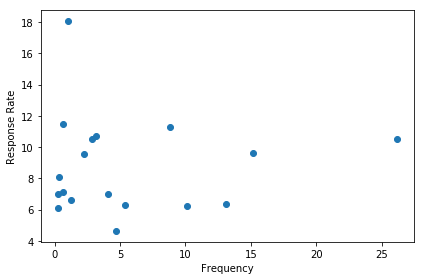

TARGET,0,1,Count,Frequency,Frequnecy,Response_Rate,Frequnecy_Cumu
OCCUPATION_TYPE,,,,,,,
laborers,39602,4657,44259,26.178224,26.18,10.52,26.18
sales staff,23148,2458,25606,15.145385,15.15,9.60,41.33
core staff,20683,1410,22093,13.067523,13.07,6.38,54.40
managers,16032,1064,17096,10.111908,10.11,6.22,64.51
drivers,13261,1683,14944,8.839047,8.84,11.26,73.35
high skill tech staff,8522,571,9093,5.378309,5.38,6.28,78.73
accountants,7517,365,7882,4.662029,4.66,4.63,83.39
medicine staff,6391,480,6871,4.064045,4.06,6.99,87.45
security staff,4798,574,5372,3.177420,3.18,10.69,90.63


In [56]:
# Examine the frequency and response rate of each category of a single feature
df_ct = func_cat_crosstab(df_X_train["OCCUPATION_TYPE"], df_y_train, sortby='Frequency')
display(df_ct)

In [21]:
def func_eda_hist_by_label_plot_hicard(df_X, Y, prefix='', figsize=(6,4), bins=10, dir_png='../reports/figures/'):
    """function to plot the normalized probability density distribution
    Keyword arguments: df_X (feature dataframe), y (label pandas series), dir_png (output dir); Return: PNG files
    """
    import numpy as np
    
    y_uniques = Y.unique()  # unique labels, e.g. 0 or 1
    
    for col in df_X.columns:
        # filter nan vales 
        mask = ~df_X[col].isnull()
        x = df_X.loc[mask, col]
        y = Y[mask]
        
        # plot
        fig = plt.figure(figsize=figsize)
        plt.hist([x[y == y_unique] for y_unique in y_uniques], 
                 label=y_uniques, bins=bins,
                 weights=[np.ones(x[y == y_unique].count()) / x[y == y_unique].count() for y_unique in y_uniques])#density=True)
        plt.xlabel(col)
        plt.xticks(rotation='vertical')
#         plt.ylabel(col)
        plt.legend()
        plt.tight_layout()
#         plt.savefig(dir_reports_figures+'eda-hist-'+prefix+col+'.png')
#         plt.close(fig)
        plt.show()
    
    return

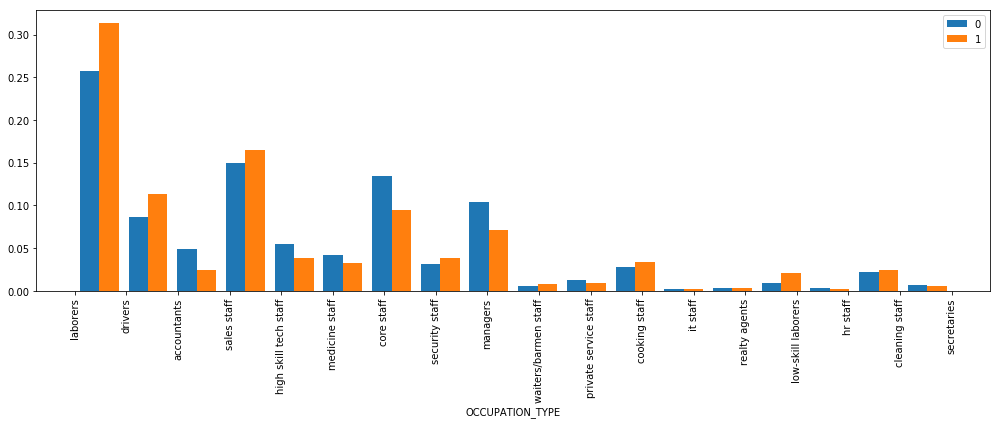

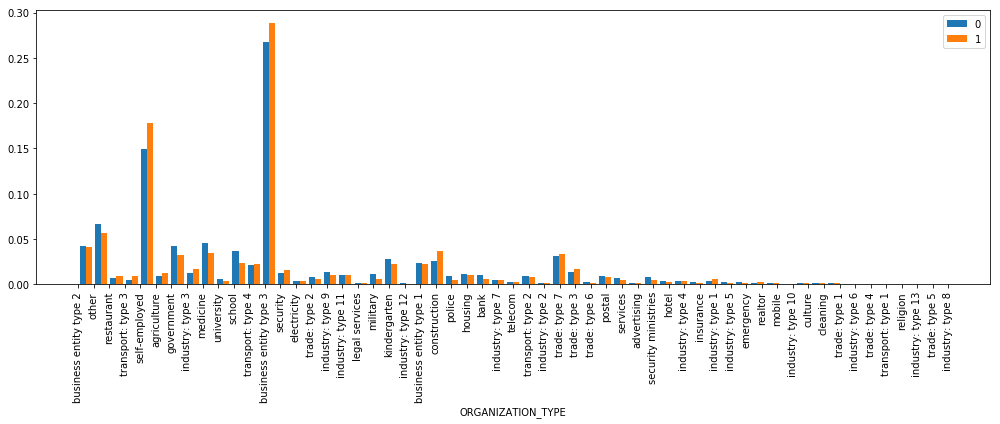

In [22]:
# the plots below lists down the features that have 
func_eda_hist_by_label_plot_hicard(df_X_train[['OCCUPATION_TYPE']], df_y_train, figsize=(14,6), bins=18)
func_eda_hist_by_label_plot_hicard(df_X_train[['ORGANIZATION_TYPE']], df_y_train, figsize=(14,6), bins=57)

##### one-hot encoding, add column for nan

Encode both string and categorical features. 

In [57]:
print('training data shape before one-hot encoding = {}'.format(df_X_train.shape))
df_X_train = pd.get_dummies(df_X_train,columns=(feature_dict['cols_string'] + feature_dict['cols_category']),dummy_na=True, dtype=float)
print('training data shape after one-hot encoding = {}'.format(df_X_train.shape))

training data shape before one-hot encoding = (246008, 121)
training data shape after one-hot encoding = (246008, 259)


#### numerical (continuous variables)

##### remove outliers

In [58]:
df_X_train.loc[df_X_train['DAYS_EMPLOYED']>0,'DAYS_EMPLOYED'] = np.nan

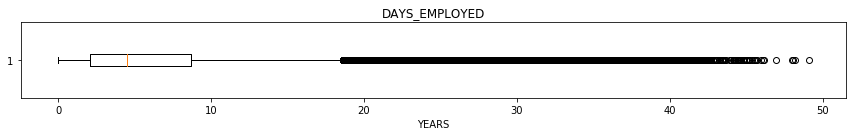

In [59]:
fig = plt.figure(figsize=(12,2))
plt.boxplot(df_X_train['DAYS_EMPLOYED'].dropna()/-365, vert=False)
plt.title('DAYS_EMPLOYED')
plt.xlabel('YEARS')
plt.tight_layout()
plt.show()

#### binary variables

##### convert True/False to 1/0 (if any)

In [60]:
df_X_train[feature_dict['cols_binary']] = df_X_train[feature_dict['cols_binary']] * 1  # True * 1 = 1

#### inpute missing values & scaling (numerical features)

Note the difference between numerical and binary-numerical features. Here, the plan is to
* fill 'median' values for numerical
* fill 'most frequent' values for binary features so that the output is always 0 or 1

##### (optional) mark existence of NaN values for selected features

Create an additional column 'feature_nan' to mark if a value is NaN. Use when the existence of values infers any meaning during data collection or interpretation. 

In [63]:
# columns with missing values 
col_w_missing_values = df_X_train.columns.values[df_X_train.isnull().sum()>0]

# or directly specify which features we would like to monitor the existence of missing values 
col_w_missing_values = ['CODE_GENDER']

# In this example, we do not monitor the missing value of any features 
col_w_missing_values = []

# example usage 
df_X_train = func_df_add_missing_flag(df_X_train, col_w_missing_values)

##### Scale and impute numerical values

In [64]:
# numerical features: use median imputer, standard scaler
scaler_standard = StandardScaler()
imp_median = SimpleImputer(strategy='median')

df_X_train[feature_dict['cols_number_exclude_binary']] = scaler_standard.fit_transform(df_X_train[feature_dict['cols_number_exclude_binary']])
df_X_train[feature_dict['cols_number_exclude_binary']] = imp_median.fit_transform(df_X_train[feature_dict['cols_number_exclude_binary']])

C:\Users\zb\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zb\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


##### Impute binary values

In [65]:
# binary features: use most_frequent, no need scaling
imp_most_freq = SimpleImputer(strategy='most_frequent')
df_X_train[feature_dict['cols_binary']] = imp_most_freq.fit_transform(df_X_train[feature_dict['cols_binary']])

##### check inputation and scaling parameters

In [66]:
# print(imp_median.statistics_)
# print(imp_most_freq.statistics_)

#### Select features to be included (used to ensure consistency in Testing Data)

In [67]:
col_X_train = df_X_train.columns.values
display(df_X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246008 entries, 181648 to 285162
Columns: 259 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_nan
dtypes: float64(227), int64(32)
memory usage: 488.0 MB


None

### Inferential Statistics

The correlation analysis below indicates that there are features that closely correlated with each other, especially features representing similar attributes of the house (e.g. FLOORSMAX_AVG vs FLORRSMAX_MEDI). 

#### Correlation among features

In [27]:
%%time
df_X_train_corr = df_X_train.corr() 

Wall time: 36.3 s


In [28]:
s = df_X_train_corr.unstack()  # unstack into a pandas series in the format of: x1, x2, correlation_coef
so = s.sort_values(kind="quicksort")
so = so.dropna()
so = so[(so>-1) & (so<1)]
print(so.shape)

(62744,)


In [30]:
print("Top 5 positively correlated feature combinations")
print(so.tail(10))  # most positively correlated
print("\n")
print("Top 5 negatively correlated feature combinations")
print(so.head(10))  # most negatively correlated


Top 5 positively correlated feature combinations
FLOORSMAX_AVG               FLOORSMAX_MEDI                0.997213
FLOORSMAX_MEDI              FLOORSMAX_AVG                 0.997213
FLOORSMIN_MEDI              FLOORSMIN_AVG                 0.997357
FLOORSMIN_AVG               FLOORSMIN_MEDI                0.997357
YEARS_BUILD_AVG             YEARS_BUILD_MEDI              0.998392
YEARS_BUILD_MEDI            YEARS_BUILD_AVG               0.998392
OBS_30_CNT_SOCIAL_CIRCLE    OBS_60_CNT_SOCIAL_CIRCLE      0.998516
OBS_60_CNT_SOCIAL_CIRCLE    OBS_30_CNT_SOCIAL_CIRCLE      0.998516
ORGANIZATION_TYPE_nan       NAME_INCOME_TYPE_pensioner    0.999655
NAME_INCOME_TYPE_pensioner  ORGANIZATION_TYPE_nan         0.999655
dtype: float64


Top 5 negatively correlated feature combinations
CODE_GENDER_m                  CODE_GENDER_f                   -0.999982
CODE_GENDER_f                  CODE_GENDER_m                   -0.999982
FLAG_EMP_PHONE                 ORGANIZATION_TYPE_nan           -0.999

#### Correlation between features and target

In [39]:
df_corr_w_y = df_X_train.corrwith(df_y_train)

df_corr_w_y = df_corr_w_y.sort_values() # 2 because the 1st and 2nd rows are ID and Target
df_corr_w_y = df_corr_w_y.dropna()
# Display correlations
print('Most Positive Correlations:\n', df_corr_w_y.tail(5))
print('\nMost Negative Correlations:\n', df_corr_w_y.head(5))

Most Positive Correlations:
 NAME_INCOME_TYPE_working       0.055596
REGION_RATING_CLIENT           0.058946
REGION_RATING_CLIENT_W_CITY    0.061283
DAYS_EMPLOYED                  0.063542
DAYS_BIRTH                     0.079467
dtype: float64

Most Negative Correlations:
 EXT_SOURCE_2                           -0.159423
EXT_SOURCE_3                           -0.155924
EXT_SOURCE_1                           -0.098932
NAME_EDUCATION_TYPE_higher education   -0.055719
CODE_GENDER_f                          -0.054576
dtype: float64


#### Distribution by Gender of Applicants

In [88]:
# summarize the proportion of default cases in each gender group: 1 = Female, 0 = Male.
df_gender = df_raw.loc[:,['CODE_GENDER','TARGET']].groupby('CODE_GENDER').agg(['count','mean'])
display(df_gender)

TARGET          
              count      mean
CODE_GENDER                  
F            202448  0.069993
M            105059  0.101419
XNA               4  0.000000

In [93]:
def _z_test_two_proportion(p, p1, p2, n1, n2): 
    ### calculate z-statistics for two proportion ###
    return np.abs((p1-p2)/np.sqrt(p*(1-p)*(1/n1+1/n2)))

In [94]:
# Calculate z-statistics
p0 = df_gender.loc['F',('TARGET','mean')]
p1 = df_gender.loc['M',('TARGET','mean')]
n0 = df_gender.loc['F',('TARGET','count')]
n1 = df_gender.loc['M',('TARGET','count')]
p = df_raw['TARGET'].mean()
print("z-statistics = {:.1f}".format(_z_test_two_proportion(p, p0, p1, n0, n1)))

z-statistics = 30.3


where,
* "count" represent the total number of applicant in each "GENDER" group. 
* "mean" represents the percentage of applicants that default in each "GENDER" group. 

Thus, the above results suggest that there is a relatively higher chance of default in "male" group. The question to be explored is whether male applicant is more likely to default? 

This can be answered with two proportion z-test: 
* Let p0 = proportion of male default application, 0.101415, and p1 = proportion of female default application, 0.069993. 

Step 1. Establish the Null Hypothesis
* H0: p0 = p1; Ha: p0 != p1; alpha = 0.05;

Step 2. Find the overall proportion
* p = 0.080729

Step 3. Calculate the z-statistics for two proportions
* z = 30.3
<img src="./two-proportion-z-test.png">

Step 4. By looking-up the z-table, the critical z-score associated with alpha/2=0.025 is
* z-score = 1.96

Step 5. Compare the z-statistics against the critical z-score, 
30.3 > 1.96, reject the Null Hypothesis! Thus, there is significant difference between the default rate of male and female applicants, and male applicants are subjected to a higher default rate. 

The script for calculating the z-statistics is shown below. 

### Pipeline for testing data

#### Apply the same pipeline as training data

In [68]:
## Genenral pre-processing: 
# unify to lower case
df_X_test[feature_dict['cols_string']] = df_X_test[feature_dict['cols_string']].apply(lambda x: x.str.lower())
# replace known missing values
df_X_test = df_X_test.replace(na_dict, np.nan)

## Categorical features
# One-hot encoding, and align column names
df_X_test = pd.get_dummies(df_X_test,columns=(feature_dict['cols_string'] + feature_dict['cols_category']),dummy_na=True, dtype=float)


## Numerical features
# Remove outliers 
df_X_test.loc[df_X_test['DAYS_EMPLOYED']>0,'DAYS_EMPLOYED'] = np.nan

## Binary features
# Conert True/False to 1/0 (if any)
df_X_test[feature_dict['cols_binary']] = df_X_test[feature_dict['cols_binary']] * 1  # True * 1 = 1

## Add missing columns
df_X_test = func_df_add_missing_flag(df_X_test, col_w_missing_values)

# Allignment of Features [additional step for testing data, before any imputation] 
# Get missing columns in the training test (which corresponds to levels that existing in training but not in test dataset for categorical variables)
missing_cols = set( df_X_train.columns ) - set( df_X_test.columns )
# Add a missing column in test set with default value equal to 0 (i.e., indicating this level does not exists)
for c in missing_cols:
    df_X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
df_X_test = df_X_test[df_X_train.columns]

## Impute missing values and scaling
# Scale and impute numerical features
df_X_test[feature_dict['cols_number_exclude_binary']] = scaler_standard.transform(df_X_test[feature_dict['cols_number_exclude_binary']])
df_X_test[feature_dict['cols_number_exclude_binary']] = imp_median.transform(df_X_test[feature_dict['cols_number_exclude_binary']])

# Impute binary features
df_X_test[feature_dict['cols_binary']] = imp_most_freq.transform(df_X_test[feature_dict['cols_binary']])


C:\Users\zb\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


#### Check dimension

In [69]:
print('training data x: {}'.format(df_X_train.shape))
print('test data x : {}'.format(df_X_test.shape))
print('training data y: {}'.format(df_y_train.shape))
print('test data y: {}'.format(df_y_test.shape))

training data x: (246008, 259)
test data x : (61503, 259)
training data y: (246008,)
test data y: (61503,)


#### target: check if need to convert to numeric

In [70]:
df_y_train = func_df_series_categorization(df_y_train)
df_y_train = func_df_series_categorization(df_y_train)

no need to covert. already numerical.
no need to covert. already numerical.


#### save pre-processed data

In [71]:
# save to pickle, ver0, raw split data
with open(dir_dat_processed+'/df_X_train.pickle', 'wb') as handle:
    pickle.dump(df_X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(dir_dat_processed+'/df_X_test.pickle', 'wb') as handle:
    pickle.dump(df_X_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(dir_dat_processed+'/df_y_train.pickle', 'wb') as handle:
    pickle.dump(df_y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(dir_dat_processed+'/df_y_test.pickle', 'wb') as handle:
    pickle.dump(df_y_test, handle, protocol=pickle.HIGHEST_PROTOCOL)    


### Hot-start: Load Pre-processed Data

In [26]:
import pickle
with open(dir_dat_processed+'/df_X_train.pickle', 'rb') as handle:
    df_X_train = pickle.load(handle)
with open(dir_dat_processed+'/df_X_test.pickle', 'rb') as handle:
    df_X_test = pickle.load(handle)
with open(dir_dat_processed+'/df_y_train.pickle', 'rb') as handle:
    df_y_train = pickle.load(handle)
with open(dir_dat_processed+'/df_y_test.pickle', 'rb') as handle:
    df_y_test = pickle.load(handle)    


In [44]:
feature_list = df_X_train.columns.values
feature_list

array(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG',
       'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG

In [40]:
X_train = df_X_train.values
X_test = df_X_test.values
y_train = df_y_train.values
y_test = df_y_test.values

In [41]:
del df_X_train, df_X_test, df_y_train, df_y_test

## Original Imbalanced Data: Quick Model with XGBoost
The F1 score is found to be extremely low due to the imbalanced nature of the dataset. 

In [48]:
start = time.time()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
models = [
          XGBClassifier(random_state=42, verbose=1, n_jobs=-1)
         ]
names = ["XGBoosting"]

df_scores = pd.DataFrame()

for model, name in zip(models, names):
    print("Executing {} model.".format(name))
    start = time.time()
    scoring = {'acc': 'accuracy',
               'prec': 'precision',
               'rec': 'recall',
               'f1': 'f1', 
               'roc_auc': 'roc_auc'}
    score = cross_validate(model, df_X_train.values, df_y_train.values, scoring=scoring,
                             cv=cv, return_train_score=False)
    df_score = pd.DataFrame(score)
    df_score.index = df_score.index.set_names(['cv'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name)
    df_scores = pd.concat([df_scores, df_score])
    
print("Total execution time = {} min.".format((time.time() - start)/60.0))

Executing XGBoosting model.
Total execution time = 7.628733332951864 min.


In [50]:
# save cross-validation results and compare model performances 
df_scores#.groupby('Name').agg(['mean','std']).T

,Name,cv,fit_time,score_time,test_acc,test_prec,test_rec,test_f1,test_roc_auc
0,XGBoosting,0,92.656,1.940,0.919251,0.490566,0.006546,0.012919,0.744755
1,XGBoosting,1,88.207,1.975,0.919475,0.625000,0.006294,0.012463,0.753370
2,XGBoosting,2,88.389,1.815,0.919414,0.600000,0.005287,0.010482,0.750096
3,XGBoosting,3,89.292,1.844,0.919473,0.692308,0.004532,0.009005,0.750617
4,XGBoosting,4,88.763,1.961,0.919412,0.640000,0.004028,0.008006,0.747310


## Model Selection with Undersampled and Balanced Dataset

To get some idea about which machine learning algorithm will perform better. 

### Under Sampling of Dataset

In [41]:
from imblearn.under_sampling import RandomUnderSampler

In [42]:
rus = RandomUnderSampler(return_indices=True, random_state=42)
%time X_rus, y_rus, id_rus = rus.fit_sample(df_X_train, df_y_train)

print('Original X size = {}'.format(df_X_train.shape))
print('Original y size = {}'.format(df_y_train.shape))
print('Under sampled X size = {}'.format(X_rus.shape))
print('Under sampled y size = {}'.format(y_rus.shape))

Wall time: 704 ms
Original X size = (246008, 259)
Original y size = (246008,)
Under sampled X size = (39720, 259)
Under sampled y size = (39720,)


In [85]:
np.unique(y_rus,return_counts=True)  # check y balance

(array([0, 1], dtype=int64), array([19860, 19860], dtype=int64))

### Cross-validation for Various Models

In [104]:
from sklearn.model_selection import cross_validate

In [136]:
start = time.time()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
models = [GaussianNB(),
          LogisticRegression(random_state=42, verbose=0, n_jobs=-1, solver='lbfgs'), 
          RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1),
          GradientBoostingClassifier(n_estimators=100, random_state=42, verbose=1),
          XGBClassifier(random_state=42, verbose=1, n_jobs=-1)
         ]
names = ["Naive Bayes","Logistic","RandomForest","GradientBoosting","XGBoosting"]

df_scores = pd.DataFrame()

for model, name in zip(models, names):
    print("Executing {} model.".format(name))
    start = time.time()
    scoring = {'acc': 'accuracy',
               'prec': 'precision',
               'rec': 'recall',
               'f1': 'f1', 
               'roc_auc': 'roc_auc'}
    score = cross_validate(model, X_rus, y_rus, scoring=scoring,
                             cv=cv, return_train_score=False)
    df_score = pd.DataFrame(score)
    df_score.index = df_score.index.set_names(['cv'])
    df_score.reset_index(inplace=True)
    df_score.insert(loc=0, column='Name', value=name)
    df_scores = pd.concat([df_scores, df_score])
    
print("Total execution time = {} min.".format((time.time() - start)/60.0))

Executing Naive Bayes model.
Executing Logistic model.
Executing RandomForest model.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=

Executing GradientBoosting model.
      Iter       Train Loss   Remaining Time 
         1           1.3643           42.27s
         2           1.3460           41.70s
         3           1.3305           41.35s
         4           1.3173           40.85s
         5           1.3060           40.43s
         6           1.2963           39.86s
         7           1.2874           39.22s
         8           1.2796           38.71s
         9           1.2729           38.25s
        10           1.2667           38.41s
        20           1.2272           33.15s
        30           1.2048           29.11s
        40           1.1912           24.63s
        50           1.1811           20.58s
        60           1.1729           16.36s
        70           1.1660           12.25s
        80           1.1603            8.15s
        90           1.1557            4.06s
       100           1.1510            0.00s
      Iter       Train Loss   Remaining Time 
         1         

In [139]:
with open(dir_reports+'/cv_model_selection.pickle', 'wb') as handle:
    pickle.dump(df_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [137]:
# save cross-validation results and compare model performances 
df_scores.groupby('Name').agg(['mean','std']).T

Name               GradientBoosting  Logistic  Naive Bayes  RandomForest  \
cv           mean          2.000000  2.000000     2.000000      2.000000   
             std           1.581139  1.581139     1.581139      1.581139   
fit_time     mean         41.281400  8.759200     0.192000      5.350000   
             std           0.792911  0.693370     0.003674      0.352517   
score_time   mean          0.179200  0.031200     0.259800      1.097200   
             std           0.020401  0.003271     0.004087      0.057686   
test_acc     mean          0.684668  0.681219     0.558359      0.672885   
             std           0.005542  0.002379     0.010952      0.003939   
test_prec    mean          0.684788  0.683578     0.538743      0.681128   
             std           0.004353  0.004033     0.008854      0.006290   
test_rec     mean          0.684290  0.674874     0.817825      0.650302   
             std           0.009209  0.003967     0.024617      0.004826   
test_f1      mean          0.684529  0.679183     0.649312      0.665331   
             std           0.006624  0.001748     0.002481      0.002828   
test_roc_auc mean          0.749074  0.743590     0.624188      0.733938   
             std           0.005526  0.004782     0.001123      0.005607   

Name               XGBoosting  
cv           mean    2.000000  
             std     1.581139  
fit_time     mean   19.993200  
             std     2.406601  
score_time   mean    0.391800  
             std     0.078818  
test_acc     mean    0.684894  
             std     0.005942  
test_prec    mean    0.684982  
             std     0.004435  
test_rec     mean    0.684592  
             std     0.010756  
test_f1      mean    0.684771  
             std     0.007365  
test_roc_auc mean    0.749054  
             std     0.006193

Based on the above comparison, XGBoosting provides the best results, followed by Logistic Regression, and RandomForest. Thus, for the subsequent model tuning, XGBoosting will be adopted. 

## XGBoosting

### Feature Importance (based on Undersampled Dataset)

In [51]:
%%time
clf = XGBClassifier(random_state=42, verbose=1, n_jobs=-1)
clf.fit(X_rus, y_rus)

Wall time: 17.7 s


#### Top 30 features

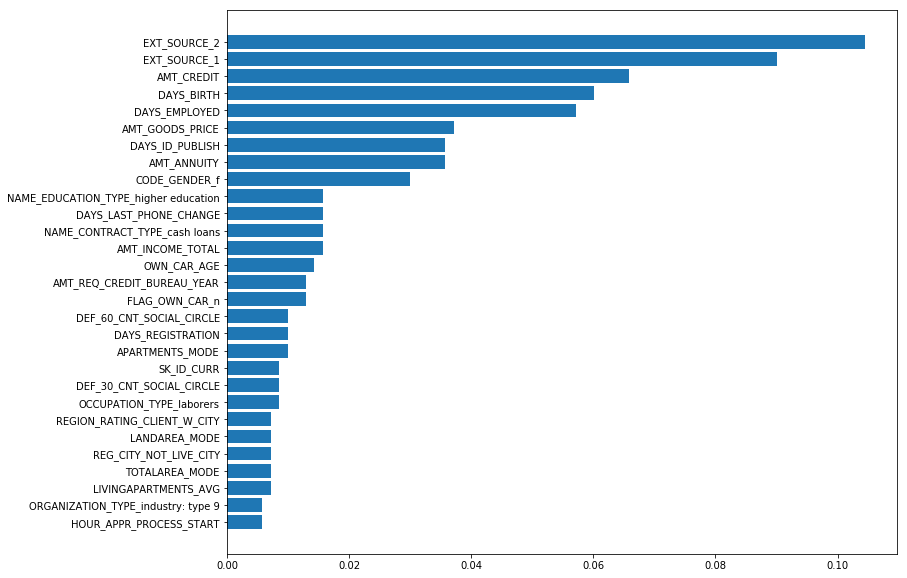

In [88]:
topn = 30
indices = np.argsort(clf.feature_importances_)
plt.figure(figsize=[12,10])
plt.barh(feature_list[indices][-topn:-1], clf.feature_importances_[indices][-topn:-1])
plt.show()

#### Cumulative Feature Importance
The feature importance is sorted and the cumulative feature importance is plotted below. It is found that most of the features contribute very little to the final prediction. For example, the bottom approximately 180 features only contribute cumulatively 1% of total feature importance. Thus, in the following analysis, these 180 features will be dropped. 

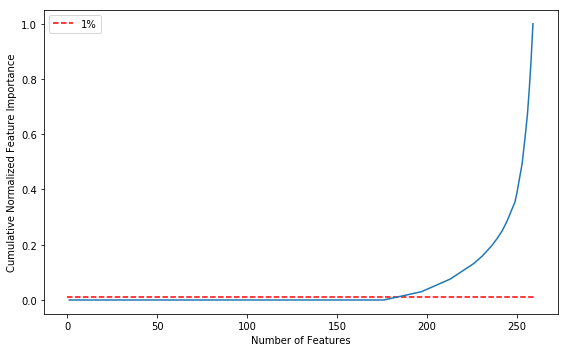

In [93]:
### Cumulative feature importance vs. number of features (sorted from low to high importance)
plt.figure(figsize=[8,5])
plt.plot(range(1,len(clf.feature_importances_)+1), np.cumsum(clf.feature_importances_[indices])/np.sum(clf.feature_importances_))
plt.hlines(0.01, 0, len(clf.feature_importances_)+1, colors='r', linestyles='--', label='1%')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Normalized Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()

### Model with Reduced Features

In [108]:
indices_fi99 = indices[180:len(feature_list)] 

In [110]:
feature_list_fi99 = feature_list[indices_fi99] 
print("Select {} features that covers 99% of the cumulative feature importance.".format(len(feature_list_fi99)))

Select 79 features that covers 99% of the cumulative feature importance.


In [100]:
start = time.time()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
clf_xgb_reduced_features = XGBClassifier(random_state=42, verbose=1, n_jobs=-1)

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'f1': 'f1', 
           'roc_auc': 'roc_auc'}

score = cross_validate(clf_xgb_reduced_features, df_X_train[feature_list_fi99].values, df_y_train.values, scoring=scoring, 
                       cv=cv, return_train_score=False)
df_score_reduced_features = pd.DataFrame(score)
# df_score.index = df_score.index.set_names(['cv'])
# df_score.reset_index(inplace=True)
# df_score.insert(loc=0, column='Name', value=name)
# df_scores = pd.concat([df_scores, df_score])
    
print("Total execution time = {} min.".format((time.time() - start)/60.0))

Total execution time = 2.8440666675567625 min.


In [107]:
df_score_reduced_features.agg(['mean','std'])

,fit_time,score_time,test_acc,test_prec,test_rec,test_f1,test_roc_auc
mean,33.221600,0.834400,0.919413,0.608915,0.005237,0.010378,0.749210
std,2.019859,0.028023,0.000047,0.046591,0.001226,0.002403,0.003278


In [111]:
start = time.time()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
clf_xgb_reduced_features_undersample = XGBClassifier(random_state=42, verbose=1, n_jobs=-1)

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'f1': 'f1', 
           'roc_auc': 'roc_auc'}

score = cross_validate(clf_xgb_reduced_features_undersample, X_rus[:,indices_fi99], y_rus, scoring=scoring, 
                       cv=cv, return_train_score=False)
df_score_reduced_features_undersample = pd.DataFrame(score)
print("Total execution time = {} min.".format((time.time() - start)/60.0))
df_score_reduced_features_undersample.agg(['mean','std'])

Total execution time = 0.47051666577657064 min.


,fit_time,score_time,test_acc,test_prec,test_rec,test_f1,test_roc_auc
mean,5.498800,0.131000,0.686078,0.686672,0.684441,0.685535,0.749141
std,0.538206,0.006042,0.005517,0.004163,0.010635,0.006976,0.006152


In [116]:
with open(dir_reports+'/df_score_reduced_features_undersample.pickle', 'wb') as handle:
    pickle.dump(df_score_reduced_features_undersample, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [115]:
with open(dir_reports+'/clf_xgb_reduced_features_undersample.pickle', 'wb') as handle:
    pickle.dump(clf_xgb_reduced_features_undersample, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Test with Oversampling

Test if there will be any boost in performance using over-sampling. 

#### Oversampling using SMOTE

In [42]:
%%time
# upsampling 
from imblearn.over_sampling import SMOTE
X_upsampled, y_upsampled = SMOTE().fit_resample(df_X_train, df_y_train)

Wall time: 3min 38s


In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_upsampled.shape)
print(y_upsampled.shape)
# save to pickle
with open(dir_dat_processed+"X_upsampled.pickle", 'wb') as handle:
    pickle.dump(X_upsampled, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(dir_dat_processed+"y_upsampled.pickle", 'wb') as handle:
    pickle.dump(y_upsampled, handle, protocol=pickle.HIGHEST_PROTOCOL)

(246008, 259)
(246008,)
(452296, 259)
(452296,)


In [112]:
# read from pickle
with open(dir_dat_processed+"X_upsampled.pickle", 'rb') as handle:
    X_upsampled = pickle.load(handle)
with open(dir_dat_processed+"y_upsampled.pickle", 'rb') as handle:
    y_upsampled = pickle.load(handle)
    

#### Cross-validation

In [113]:
start = time.time()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
clf_xgb_reduced_features_upsample = XGBClassifier(random_state=42, verbose=1, n_jobs=-1)

scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'f1': 'f1', 
           'roc_auc': 'roc_auc'}

score = cross_validate(clf_xgb_reduced_features_upsample, X_upsampled[:,indices_fi99], y_upsampled, scoring=scoring, 
                       cv=cv, return_train_score=False)
df_score_reduced_features_upsample = pd.DataFrame(score)
print("Total execution time = {} min.".format((time.time() - start)/60.0))
df_score_reduced_features_upsample.agg(['mean','std'])

Total execution time = 6.978900003433227 min.


,fit_time,score_time,test_acc,test_prec,test_rec,test_f1,test_roc_auc
mean,82.050400,1.507000,0.942909,0.991044,0.893897,0.939966,0.972463
std,3.666578,0.047901,0.000950,0.000703,0.001807,0.001047,0.000846


In [117]:
with open(dir_reports+'/df_score_reduced_features_upsample.pickle', 'wb') as handle:
    pickle.dump(df_score_reduced_features_upsample, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Final Model

### Train Final Model with the Whole Dataset

In [123]:
%%time
clf_xgb_reduced_features_upsample.fit(X_upsampled[:,indices_fi99], y_upsampled)
with open(dir_reports+'/clf_xgb_reduced_features_upsample.pickle', 'wb') as handle:
    pickle.dump(clf_xgb_reduced_features_upsample, handle, protocol=pickle.HIGHEST_PROTOCOL)

Wall time: 1min 39s


### Performance on Test Set

In [118]:
with open(dir_reports+'/clf_xgb_reduced_features_upsample.pickle', 'rb') as handle:
    clf_xgb_reduced_features_upsample = pickle.load(handle)

In [124]:
# Prediction Training and Test
y_pred_test = clf_xgb_reduced_features_upsample.predict(df_X_test[feature_list_fi99].values)

In [129]:
print("Test accuracy = {:.6f}".format(accuracy_score(df_y_test.values, y_pred_test)))

unique_label = np.unique(df_y_test.values)
cm = confusion_matrix(df_y_test.values, y_pred_test, labels=unique_label)
print(pd.DataFrame(cm, 
                   index=['true:{:}'.format(x) for x in unique_label],
                   columns=['pred:{:}'.format(x) for x in unique_label]))

cr = classification_report(df_y_test.values, y_pred_test, output_dict=True)
cr_df = pd.DataFrame(cr)
display(cr_df)

Test accuracy = 0.916069
        pred:0  pred:1
true:0   56118     420
true:1    4742     223


,0,1,micro avg,macro avg,weighted avg
f1-score,0.956030,0.079529,0.916069,0.517780,0.885272
precision,0.922083,0.346812,0.916069,0.634448,0.875643
recall,0.992571,0.044914,0.916069,0.518743,0.916069
support,56538.000000,4965.000000,61503.000000,61503.000000,61503.000000


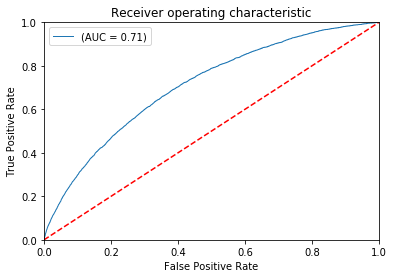

In [130]:
from sklearn.metrics import roc_curve, auc
probas_ = clf_xgb_reduced_features_upsample.predict_proba(df_X_test[feature_list_fi99].values)
fpr, tpr, thresholds = roc_curve(df_y_test.values, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1.0, label='(AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

## Model Interpretation

### Feature Importance

In [213]:
df_fi = pd.DataFrame({'feature': feature_list_fi99, 'importance': clf_xgb_reduced_features_upsample.feature_importances_})
df_fi.sort_values(by=['importance'], ascending=False, inplace=True)
df_fi.head()

,feature,importance
78,EXT_SOURCE_3,0.108883
63,AMT_REQ_CREDIT_BUREAU_YEAR,0.083095
77,EXT_SOURCE_2,0.075931
32,NAME_INCOME_TYPE_working,0.065903
45,NAME_EDUCATION_TYPE_secondary / secondary special,0.047278


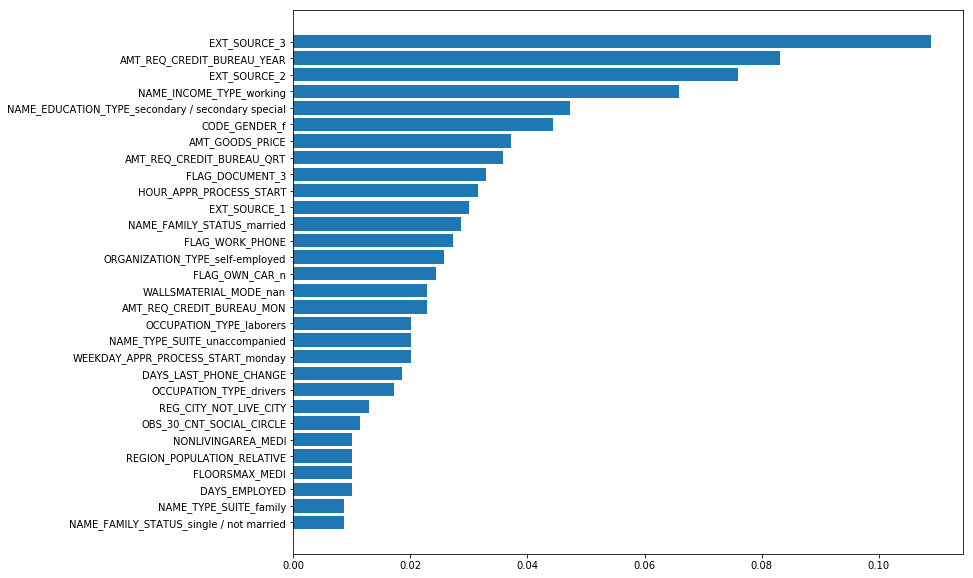

In [215]:
topn = 30
plt.figure(figsize=[12,10])
plt.barh(df_fi['feature'].iloc[0:topn],df_fi['importance'].iloc[0:topn])
plt.gca().invert_yaxis()
plt.show()

### SHAP: Individual Analysis

In [228]:
# combine a dataframe listing the outcomes for testing dataset
df_test_results = pd.DataFrame({'test_label': df_y_test.values, 'test_prediction': y_pred_test, 'test_prob_0': probas_[:,0], 'test_prob_1': probas_[:,1]})
df_test_results.head()

,test_label,test_prediction,test_prob_0,test_prob_1
0,0,0,0.931791,0.068209
1,0,0,0.783285,0.216715
2,0,1,0.484794,0.515206
3,0,0,0.826572,0.173428
4,0,0,0.549313,0.450687


In [229]:
# find the top individual applicants that are classified as positive (i.e., possible to default)
df_test_results.sort_values(by=['test_prob_1'], ascending=False).head()

,test_label,test_prediction,test_prob_0,test_prob_1
57359,1,1,0.314505,0.685495
6653,0,1,0.333423,0.666577
24645,1,1,0.342672,0.657328
6117,1,1,0.344512,0.655488
8552,1,1,0.346734,0.653266


Case that is correctly predicted. 

In [227]:
shap.initjs()
n = 57359
X = df_X_test[feature_list_fi99].iloc[n:n+1,:]

explainer = shap.TreeExplainer(clf_xgb_reduced_features_upsample)
shap_values = explainer.shap_values(X.values)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], link='logit')

Case that is wrongly predicted. 

In [230]:
shap.initjs()
n = 6653
X = df_X_test[feature_list_fi99].iloc[n:n+1,:]

explainer = shap.TreeExplainer(clf_xgb_reduced_features_upsample)
shap_values = explainer.shap_values(X.values)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], link='logit')

### Business Value

The data provider, Home Credit Group [http://www.homecredit.net/], is an international consumer finance provider focusing on responsible lending primarily to people with little or no credit history. In many markets, Home Credit Group provides interest-free consumer loans, profiting from the partnership with the manufactures and/or retailers. 

The development of Home Loan Credit Risk predictive model is to give unbanked people access to financial services and also help the financial institute managing the risk of default. The baseline condition for the present model is the situation that all the people appear in the dataset are not given any loans, and the financial institute has no assess to such market (i.e., a zero baseline with no gain and lost). 

From the perspective of financial institute, the results of the predictive model can be compared against the label and interpreted as follows, 
* True positive: potential default cases are successfully predicted, which prevents unnecessary loss;
* True negative: healthy loans that generate interest revenue;
* False positive: loans are not provided even though applicants will not default, which reduces access to good customers;
* False negative: loans are provided and default happens, which leads to direct loss.

To assess the effectiveness of the predictive model. The total gain from interest revenue and total loss from default loans can be summed up. A positive total indicates the predictive model helps the financial institute to leaverage on the unbank market; while a negative total indicates the predictive model is not useful at all. 

Here, we will conduct the calculation using the test data. 

In [231]:
#load model
with open(dir_reports+'/clf_xgb_reduced_features_upsample.pickle', 'wb') as handle:
    pickle.dump(clf_xgb_reduced_features_upsample, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [232]:
# Prediction on Test Data, and generate confusion matrix
y_pred_test = clf_xgb_reduced_features_upsample.predict(df_X_test[feature_list_fi99].values)
unique_label = np.unique(df_y_test.values)
cm = confusion_matrix(df_y_test.values, y_pred_test, labels=unique_label)
print(pd.DataFrame(cm, 
                   index=['true:{:}'.format(x) for x in unique_label],
                   columns=['pred:{:}'.format(x) for x in unique_label]))

        pred:0  pred:1
true:0   56118     420
true:1    4742     223


Following the prediction model results, 
* True positive: 223 default cases are prevented
* True negative: 56118 healthy loans are approved
* False positive: 420 applications are incorrectly rejected
* False negative: 4742 default cases are expected to happen and cause financial loss

It is noted that the loan amount of individual applicants are not provided. Thus, to test the sensitivity, it is assumed that each applicant will borrows an average home loan of \$300,000 for 20 years with an interest rate of 6\%. The total interest paid to the financial institute can be calculating using online loan calculators as below. To simplify the calculation, the following assumptions are made: 
* Each healthy loan will bring \$215,830.36 interest revenue to the financial institute
* Each default loan will leads to total loss of the loan amount, \$300,000, which is very conservative

![Image of Loan Calculator](loan_calculator.png)

Thus, the total interest gain from this new market is: 

In [247]:
interest_gain_per_loan = 215830.36
loss_per_default = 300000
num_healthy_loan = cm[0,0]
num_default_loan = cm[1,0]
gain = interest_gain_per_loan*num_healthy_loan
loss = loss_per_default*num_default_loan
net_gain = gain - loss
print("Gain = ${:.2f}".format(gain))
print("Loss = ${:.2f}".format(loss))
print("Net Gain = ${:.2f}".format(net_gain))

Gain = $12111968142.48
Loss = $1422600000.00
Net Gain = $10689368142.48


Another scenario:
![Image of Loan Calculator](loan_calculator_sc2.png)

In [246]:
# Another scenario
interest_gain_per_loan = 661.85
loss_per_default = 10000
num_healthy_loan = cm[0,0]
num_default_loan = cm[1,0]
gain = interest_gain_per_loan*num_healthy_loan
loss = loss_per_default*num_default_loan
net_gain = gain - loss
print("Gain = ${:.2f}".format(gain))
print("Loss = ${:.2f}".format(loss))
print("Net Gain = ${:.2f}".format(net_gain))

Gain = $37141698.30
Loss = $47420000.00
Net Gain = $-10278301.70


Last scenario:
![Image of Loan Calculator](loan_calculator_sc3.png)

In [248]:
interest_gain_per_loan = 27482.27
loss_per_default = 100000
num_healthy_loan = cm[0,0]
num_default_loan = cm[1,0]
gain = interest_gain_per_loan*num_healthy_loan
loss = loss_per_default*num_default_loan
net_gain = gain - loss
print("Gain = ${:.2f}".format(gain))
print("Loss = ${:.2f}".format(loss))
print("Net Gain = ${:.2f}".format(net_gain))

Gain = $1542250027.86
Loss = $474200000.00
Net Gain = $1068050027.86


Compare to Home Loan Group's Financial Summary: interest revenue is around 1 to 2 billion EURO per year. 

[http://www.homecredit.net/investors/key-financial-data.aspx]
![Image of Loan Calculator](Home_Loan_Credit_Summary.png)

The actual loss or gain will depends on the size of loan and tenure. However, there is clearly room to improve the performance of predictive model, especialy to further reduce the False Negative cases, which leads to default of the loans. Possible ways to improve the model performance includes: 
* Tuning the threshold of classification
* Fine tuning of the hyper-parameters using grid search or random search
* Include more data, and/or data source
* More feature engineering 
* Ensemble modeling 

which will left for future investigations.

**END**